# Google Drive Setup

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

PROJECT_PATH = '/content/gdrive/My Drive/BYB Projects/BYB 2021 Fellows/Projects/Hacker Hand/code'

Mounted at /content/gdrive


# Required Libraries

In [2]:
import numpy as np
import os
import pandas as pd


from matplotlib import pyplot as plt
from scipy import signal
from scipy.io import wavfile
from scipy.signal import butter, filtfilt, hilbert, decimate


# hlines and vlines became a thing in v4.12
!pip install plotly==4.12.0
import plotly
import plotly.express as px
import plotly.graph_objects as go

plotly.__version__

     |████████████████████████████████| 13.1 MB 44 kB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


'4.12.0'

# Helper Functions

## Load File

In [3]:
def load_wav_data( filename, colors, bad_channels=None):
    
    fs, data = wavfile.read( filename)
    t = np.arange( len( data)) / fs

    print('''\n_________________________________
    FILE DESCRIPTION:
    ---------------------------------
    || File Name: {}
    || Raw Data Channels: {}
    || Raw Data Samples: {}
    || Sampling Frequency: {} Hz
    || Recording Length: {:.3f} s
    ---------------------------------
    _________________________________\n'''.format( filename[ len( PROJECT_PATH) + 1: ],
                                                data.shape[1],
                                                data.shape[0], 
                                                fs, 
                                                t[-1]))

    if bad_channels is not None:
        bad_channels.sort(reverse = True)
        for chan in bad_channels:
            print( f'\nWARNING: Deleting channel {chan} at index {chan - 1}')
            data = np.delete( data, (chan - 1), axis = 1)
            colors = np.delete( colors, (chan - 1))

    # Predefined fs of Spilkerbox Pro divided by 6 chans
    fs = 6666 / 6
    t = np.arange( len( data)) / fs 

    print('''\n_________________________________
    LOADED FILE SUMMARY:
    ---------------------------------
    || File Name: {}
    || Raw Data Channels: {}
    || Raw Data Samples: {}
    || Sampling Frequency: {} Hz
    || Recording Length: {:.3f} s
    ---------------------------------
    _________________________________\n'''.format( filename[ len( PROJECT_PATH) + 1: ],
                                                data.shape[1],
                                                data.shape[0], 
                                                fs, 
                                                t[-1]))

    return colors, t, fs, data

## Remove Spikes

In [4]:
def adhoc_fix_data( data, n_channels, threshold=10000):
    
    fixed_data = data.copy()

    for chan in range( n_channels):
        if threshold < 0:
            glitches = np.where( data[ :, chan] < threshold)[0]
      
        else:
            glitches = np.where( data[:, chan] > threshold)[ 0]
        
        for i in glitches:   
            fixed_data[ i, chan] = data[ i-1, chan]

    return fixed_data

## Decimate Data

In [5]:
def decimate_data( data, fs, target_fs = 200):
    down_factor = int( fs / target_fs)
    down_data = decimate( data, down_factor, axis = 0)
    down_fs = fs / down_factor
    down_t = np.arange( len( down_data)) / down_fs

    print('''\n_______________________________
    DOWNSAMPLING LOG:
    -------------------------------
    || Starting Frequency: {} ===>> Target Frequency: {}
    || Raw Data Sample Count: {} ===>> New Sample Count: {}
    || Raw Sampling Frequency: {} Hz ===>> New Sampling Frequency: {} Hz
    || Recording Length: {:.3f} s ===>> New Recording Length: {:.3f} s
    -------------------------------
    _______________________________\n'''.format( fs, target_fs,
                                                len( data), len(down_data),
                                                fs, down_fs,
                                                len( data) / fs, down_t[-1]))

    return down_t, down_fs, down_data

## Scale Data

In [6]:
# def normalize_data(data):
#     minvals = np.min( data, axis = 0)
#     maxvals = np.max( data, axis = 0)
#     ranges = maxvals - minvals
#     print( f'{data.shape} - {minvals.shape} / {ranges.shape}')
#     norm_data = ( data - minvals) / ranges
    
#     return norm_data    

In [7]:
def scale_data( data):
    means = np.mean( data, axis = 0)
    stds = np.std( data, axis = 0)
    stdz_data = ( data - means) / stds
    
    print('''\n_______________________________
    SCALING LOG:
    -------------------------------
    Channel Means:
    {}
    Channel Standard Deviations:
    {}
    Data Before:
    {}
    Data After:
    {}
    '''.format(means,
               stds,
               data[0],
               stdz_data[0])
    )

    return stdz_data
    


## Smooth Data

In [8]:
# def smooth_data (data, fs):
#     smooth_data = []

#     for i in range(1, len(data)-1):
#         smooth_sample = np.sum(data[i-1:i+1,:], axis=0) / 3
#         if i == 1:
#             smooth_data = smooth_sample
#         else:
#             smooth_data = np.vstack( (smooth_data, smooth_sample))
    
#     smooth_t = np.arange( len(smooth_data)) / fs
#     return smooth_t, smooth_data

## Moving RMS

In [9]:
# def compute_moving_rms( data, fs, window_len_t = 0.250, window_step_t = 0.125):
#     '''
#     Return running RMS values of an array of data.
#     Parameters:
#         fs: sampling frequency
#         data: signal samples
#         window_size_t: size of the RMS window in seconds
#         window_increase: step size in seconds when sliding the window

#     Returns:
#     RMS values computed from each window
#     '''
    
#     data = data.astype( 'float32')
#     window_len = int( window_len_t * fs) # samples
#     window_step = int( window_step_t * fs) # samples
  
#     n_windows = int( ( len( data) - window_len) / window_step)

#     for i in range(n_windows):
#         start_i =  i * window_step
#         end_i = start_i + window_len

#         window_data = data[ start_i : end_i, :]
    
#         rms_i = np.sqrt( np.mean( np.square( window_data), axis = 0))
    
#         if i == 0:
#             rms = np.asarray(rms_i)
#         else:
#             rms = np.vstack( (rms, rms_i))
#     # print( rms.shape)
#     rms_t = window_step_t * np.arange( len( rms))
#     return rms_t, rms

## Sliding MAV

In [10]:
def compute_moving_mav( data, fs, frame_len_sec, overlap):
    
    data = data.astype('float32')
    
    frame_len = int( frame_len_sec * fs) # from time domain to adimensional time domain
    
    frame_step = int( ( 1 - overlap) * frame_len)

    n_frames = int( ( len(data) - frame_len) / frame_step)

    for i in range( n_frames):
        i_start = i * frame_step
        i_end = i_start + frame_len

        frame_data = data[ i_start : i_end, :]

        frame_data_rec = np.absolute( frame_data)

        mav_i = np.mean( frame_data_rec, axis = 0)

        if i == 0:
            mav = np.asarray(mav_i)
        else:
            mav = np.vstack( (mav, mav_i))

    mav_timestamps = ( frame_step / fs) * np.arange( len(mav))
    return mav_timestamps, mav


In [11]:
def compute_moving_avg( data, fs, frame_len_sec, overlap):
    data = data.astype('float32')
    frame_len = int( frame_len_sec * fs)
    frame_step = int( (1 - overlap) * frame_len)
    n_frames = int( (len(data) - frame_len) / frame_step)

    for i in range (n_frames):
        i_start = i * frame_step
        i_end = i_start + frame_len

        frame_data = data[i_start:i_end,:]
        avg_i = np.mean(frame_data, axis=0)

        if i == 0:
            avg = np.asarray(avg_i)
        else:
            avg = np.vstack((avg, avg_i))
    
    avg_timestamps = ( frame_step / fs) * np.arange( len(avg))
    return avg_timestamps, avg


In [12]:
def get_hysteretic_triggers( data, up_thresh, lo_thresh):
    # State Macros
    UNLOCKED = 0
    LOCKED = 1
  
    # Initial Conditions
    state = UNLOCKED
    next_state = UNLOCKED

    # Output Array
    hyst_trigs = []

    for sample in data:
        # Update state
        state = next_state

        if state == UNLOCKED:
            if sample >= up_thresh:
                next_state = LOCKED
                hyst_trigs.append( True)
            else:
                hyst_trigs.append( False)
        
        else:
            if sample <= lo_thresh:
                next_state = UNLOCKED
            hyst_trigs.append( False)

    return hyst_trigs

## Remove Repeated Triggers

In [13]:
def remove_repeated(triggers, n_seg):
    ret_triggers = np.copy(triggers)
    # Valid triggers are indices ( positive ints)
    # Assign a negative number to mark false triggers for deletion
    DELETE_FLAG = -1

    i = 0
    for j in range (1, len( ret_triggers)):
        if ret_triggers[j] - ret_triggers[i] <= n_seg:
            ret_triggers[j] = DELETE_FLAG
        else:
            i = j

    return ret_triggers

## Plotting functions

In [14]:
def plot_channels( data, n_channels, t):
  fig = go.Figure()
  for chan in range( n_channels):
    fig.add_trace( go.Scatter( x = t, 
                              y = data[:, chan],
                              mode = 'lines',
                              name = f'EMG {chan + 1}'))
  return fig

# Set Data Directory and List Contents

In [15]:
data_dir = os.path.join( PROJECT_PATH, 'data')
wav_files = [os.path.join( data_dir, filepath) for filepath in os.listdir( data_dir) if filepath.endswith( '.wav')]

for index, wav_file in enumerate( wav_files):
    print(f'{index}: {wav_file[ len( data_dir) + 1:]}')

0: emg-test1.wav
1: raw-emg.wav
2: no-envolpe.wav
3: envelope.wav
4: protocol-0a-001.wav
5: protocol-0b-001.wav
6: env-spiker-pro.wav
7: raw-spiker-pro.wav
8: env-5c5f.wav
9: raw-5c5f.wav
10: 5c5f-raw-70.wav
11: 5c5f-env-70.wav
12: 5c5f-env-50-tim.wav
13: 5c5f-env-75.wav
14: 5c5f-env-55-prot-02.wav
15: 60-cnt-75-bpm.wav
16: 60-cnt-60-bpm.wav


# Load Wave File

Load from local directory by choosing the appropriate index from the list above.
Remove bit-comm spikes from the data if necessary.

In [16]:
PLOTLY_DURATION = 650
COLORS = ['#87E911',    # Green
          '#F2CA19',    # Yellow
          '#0057E9',    # Blue
          '#E11845',    # Red
          '#FF08BD',    # Pink
          '#F77F00'     # Orange
          ]

In [17]:
# LOAD
COLORS, t, fs, data = load_wav_data( wav_files[15], colors = COLORS, bad_channels=[4])
n_channels = data.shape[1]

# FIX
data = adhoc_fix_data( data, n_channels, threshold=-20000)
data = adhoc_fix_data( data, n_channels, threshold=6000)


# DOWNSAMPLE
t, fs, data = decimate_data(data, fs)
down_fig = plot_channels( data[ : int( PLOTLY_DURATION * fs), :], 
                         n_channels, 
                         t[ : int( PLOTLY_DURATION * fs)])


# SCALE
data = scale_data( data)
scale_fig = plot_channels( data[ : int(PLOTLY_DURATION * fs), :], 
                         n_channels, 
                         t[: int(PLOTLY_DURATION * fs)]
)

scale_fig.show()
NORM_LIMS = np.asarray([3, 22])
norm_lims = NORM_LIMS * (10000.0 / 6666) # equal to (10kHz/n_chans) / (6666Hz/n_chans)

print(norm_lims)

Output hidden; open in https://colab.research.google.com to view.

In [18]:
rect_data = np.abs(data)

norm_lims_samples = norm_lims * fs
interval_idx_list = np.where((t > norm_lims[0]) & (t < norm_lims[1]))[0]
norm_max = np.amax(data[ interval_idx_list], axis=0)

print(rect_data[0,:])
print(norm_max)
norm_data = rect_data / norm_max
print(norm_data[0,:])

norm_fig = plot_channels( norm_data[ : int(PLOTLY_DURATION * fs), :], 
                         n_channels, 
                         t[: int(PLOTLY_DURATION * fs)]
)

norm_fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [19]:
# MOVING MAV
F_LEN = 20 / fs # [sec]
OVERLAP = 0.70 # [percent]
F_STEP =  (1 - OVERLAP) * F_LEN # [sec]

print(F_LEN, F_STEP)

MAV_DURATION = int( ( PLOTLY_DURATION - F_LEN) / F_STEP) + 1 
print(fs)

print(data.shape)
# mav_t, mav_data = compute_moving_mav( data, fs, W_LEN, OVERLAP)
mav_t, mav_data = compute_moving_avg( data, fs, F_LEN, OVERLAP)
print(mav_data.shape)

nyq_fs = fs / 2 
cutoff = 8 / nyq_fs

b, a = signal.butter(2, cutoff)

mav_filt = signal.filtfilt(b, a, mav_data, axis=0, padlen=150)

mav_sum = np.sum( mav_filt, axis = 1)

mav_fig = plot_channels( mav_filt[ mav_t < PLOTLY_DURATION, :],
                        n_channels, 
                        mav_t[ mav_t < PLOTLY_DURATION]
)

mav_filt_sum = signal.filtfilt(b, a, mav_sum, axis=0, padlen=150)

# mav_sum = mav_filt

mav_fig.add_trace( go.Scatter( x = mav_t[ mav_t < PLOTLY_DURATION], 
                              y = mav_filt_sum[ mav_t < PLOTLY_DURATION],
                              mode = 'lines',
                              name = 'EMG Total'
                    )
)

Output hidden; open in https://colab.research.google.com to view.

# Schmitt Threshold Locations

In [20]:
up_thresh = -0.100
lo_thresh = -0.750

F_LIMS = np.asarray([22.2443,	87.5312,	156.9424,	224.1579,	288.3860, 355.4724])
f_lims_mav = F_LIMS * 10000.0 / 6666.0 # equal to (10kHz/n_chans) / (6666Hz/n_chans)


threshold_check = get_hysteretic_triggers( mav_filt_sum, up_thresh, lo_thresh)
mav_triggers = np.where( threshold_check)[0]

# print(mav_triggers)

f1_triggers = [ x for x in mav_triggers if mav_t[x] > f_lims_mav[0] and mav_t[x] <= f_lims_mav[1]]
f1_triggers = np.asarray( f1_triggers)

f2_triggers = [ x for x in mav_triggers if mav_t[x] > f_lims_mav[1] and mav_t[x] <= f_lims_mav[2]]
f2_triggers = np.asarray( f2_triggers)

f3_triggers = [ x for x in mav_triggers if mav_t[x] > f_lims_mav[2] and mav_t[x] <= f_lims_mav[3]]
f3_triggers = np.asarray( f3_triggers)

f4_triggers = [ x for x in mav_triggers if mav_t[x] > f_lims_mav[3] and mav_t[x] <= f_lims_mav[4]]
f4_triggers = np.asarray( f4_triggers)

f5_triggers = [ x for x in mav_triggers if mav_t[x] > f_lims_mav[4] and mav_t[x] <= f_lims_mav[5]]
f5_triggers = np.asarray( f5_triggers)

print('''\n_______________________________
THRESHOLDING LOG
-------------------------------
Total Events Detected: {}
Finger 1: {}
Finger 2: {}
Finger 3: {}
Finger 4: {}
Finger 5: {}
-------------------------------
_______________________________\n'''.format(len( mav_triggers),
           len( f1_triggers),
           len( f2_triggers),
           len( f3_triggers),
           len( f4_triggers),
           len( f5_triggers)
           )
)

f_triggers = [f1_triggers, f2_triggers, f3_triggers, f4_triggers, f5_triggers]


_______________________________
THRESHOLDING LOG
-------------------------------
Total Events Detected: 311
Finger 1: 61
Finger 2: 55
Finger 3: 60
Finger 4: 60
Finger 5: 60
-------------------------------
_______________________________



In [21]:
# mav_triggers = remove_repeated(mav_triggers, 20)
# mav_triggers = mav_triggers[ mav_triggers >= 0]

# # print(mav_triggers)

# f1_triggers = [ x for x in mav_triggers if x > f_lims_mav[0] and x <= f_lims_mav[1]]
# f1_triggers = np.asarray( f1_triggers)

# f2_triggers = [ x for x in mav_triggers if x > f_lims_mav[1] and x <= f_lims_mav[2]]
# f2_triggers = np.asarray( f2_triggers)

# f3_triggers = [ x for x in mav_triggers if x > f_lims_mav[2] and x <= f_lims_mav[3]]
# f3_triggers = np.asarray( f3_triggers)

# f4_triggers = [ x for x in mav_triggers if x > f_lims_mav[3] and x <= f_lims_mav[4]]
# f4_triggers = np.asarray( f4_triggers)

# f5_triggers = [ x for x in mav_triggers if x > f_lims_mav[4] and x <= f_lims_mav[5]]
# f5_triggers = np.asarray( f5_triggers)

# print('''\n_______________________________
# CORRECTION LOG
# -------------------------------
# Total Events Detected: {}
# Finger 1: {}
# Finger 2: {}
# Finger 3: {}
# Finger 4: {}
# Finger 5: {}
# -------------------------------
# _______________________________\n'''.format(len( mav_triggers),
#            len( f1_triggers),
#            len( f2_triggers),
#            len( f3_triggers),
#            len( f4_triggers),
#            len( f5_triggers)
#            )
# )

# f_triggers = [f1_triggers, f2_triggers, f3_triggers, f4_triggers, f5_triggers]

In [22]:
# print(mav_triggers)
# print(mav_t[mav_triggers])

LINE_DASH = "dot"

# for trigger in mav_triggers:
#     mav_fig.add_vline(x=mav_t[trigger], line_width=2, line_dash="dash", line_color="black")

for trigger in f1_triggers:
    mav_fig.add_vline(x=mav_t[trigger], line_width=2, line_dash=LINE_DASH, line_color="red")

for trigger in f2_triggers:
    mav_fig.add_vline(x=mav_t[trigger], line_width=2, line_dash=LINE_DASH, line_color="blue")

for trigger in f3_triggers:
    mav_fig.add_vline(x=mav_t[trigger], line_width=2, line_dash=LINE_DASH, line_color="red")

for trigger in f4_triggers:
    mav_fig.add_vline(x=mav_t[trigger], line_width=2, line_dash=LINE_DASH, line_color="blue")

for trigger in f5_triggers:
    mav_fig.add_vline(x=mav_t[trigger], line_width=2, line_dash=LINE_DASH, line_color="red")

In [23]:
mav_fig.add_hline(y=up_thresh, line_color='purple', line_width=3, line_dash="dash" )
mav_fig.add_hline(y=lo_thresh, line_color='orange', line_width=3, line_dash="dash" )

mav_fig.update_layout( title_text = 'MAV of All Trials',
                       title_font_size = 30,
                       xaxis_title = r'$\text{Recording Time } [s]$',
                       yaxis_title = 'Arbitrary A/D Units',
                       template = 'plotly_white')
mav_fig.show()

Output hidden; open in https://colab.research.google.com to view.

# Event Related Plot




In [28]:
TRIGGER_OFFSET = 0
N_FRAMES = 11

from cycler import cycler
custom_cycler = (cycler(color=COLORS))

Y_MIN = 0
Y_MAX = 2.75

n_fings = len(f_triggers)


# FIGURE OBJECTS:
erp_fig, erp_axes = plt.subplots( n_channels, n_fings, 
                                 sharex=True, 
                                 sharey=True, 
                                 figsize=(16, 9),
                                 dpi=500)
erp_axes = erp_axes.flatten()
for axis in erp_axes:
    axis.grid()
merp_fig, merp_axes = plt.subplots( 1, n_fings, 
                                   sharey=True, 
                                   figsize=(16, 2),
                                   dpi=500)
merp_axes = merp_axes.flatten()
berp_fig, berp_axes = plt.subplots( 1, n_fings,
                                   sharey=True,
                                   figsize=(16, 2),
                                   dpi=500)
berp_axes = berp_axes.flatten()
x_pos = np.arange( n_channels)

list_of_mavs = []

# PLOT ERP
for f_id, trigger_list in enumerate(f_triggers):
    
    cum_mav_data = []

    for t_id, trigger in enumerate(trigger_list):
        
        i_start = trigger + TRIGGER_OFFSET
        i_end = i_start + N_FRAMES
        epoch = mav_filt[ i_start : i_end, :]
    
        for chan in range(n_channels):
    
            plot_idx = ( chan * n_fings + f_id)
            erp_axes[ plot_idx].plot( epoch[ :, chan], 
                                     color=COLORS[ chan], 
                                     alpha=0.25)
    
        if t_id == 0:
            cum_mav_data = epoch

        else:
            cum_mav_data = np.add(cum_mav_data, epoch)

# PLOT CHANNEL MEANS
    mean_mav = cum_mav_data / len( trigger_list)
    merp_axes[f_id].set_prop_cycle( custom_cycler)
    merp_axes[f_id].plot( mean_mav)
    merp_axes[f_id].grid()
    list_of_mavs.append(mean_mav)

# PLOT CHANNEL ERROR
    mu_mean_mav = np.mean( mean_mav, axis=0)
    sigma_mean_mav = np.std( mean_mav, axis=0)
    berp_axes[f_id].bar( x_pos, 
                        mu_mean_mav, 
                        yerr=sigma_mean_mav, 
                        align='center', 
                        color=COLORS,
                        capsize = 7)
    berp_axes[f_id].grid()

Output hidden; open in https://colab.research.google.com to view.

(5, 11, 5)


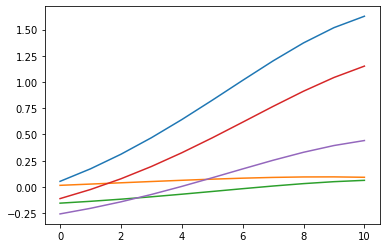

In [36]:
l_mavs = np.asarray(list_of_mavs)
print(l_mavs.shape)
plt.plot(l_mavs[0,:,0])
plt.plot(l_mavs[0,:,1])
plt.plot(l_mavs[0,:,2])
plt.plot(l_mavs[0,:,3])
plt.plot(l_mavs[0,:,4])

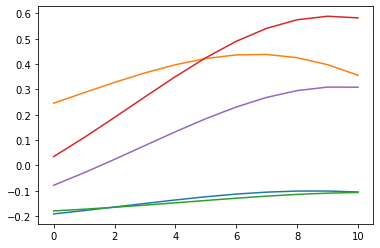

In [37]:
plt.plot(l_mavs[1,:,0])
plt.plot(l_mavs[1,:,1])
plt.plot(l_mavs[1,:,2])
plt.plot(l_mavs[1,:,3])
plt.plot(l_mavs[1,:,4])

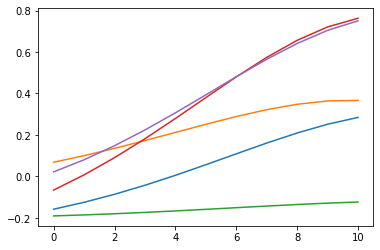

In [38]:
plt.plot(l_mavs[2,:,0])
plt.plot(l_mavs[2,:,1])
plt.plot(l_mavs[2,:,2])
plt.plot(l_mavs[2,:,3])
plt.plot(l_mavs[2,:,4])

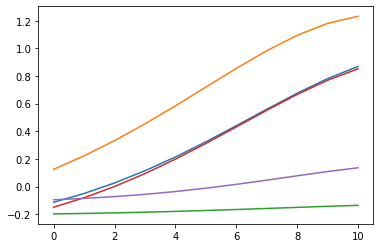

In [39]:
plt.plot(l_mavs[3,:,0])
plt.plot(l_mavs[3,:,1])
plt.plot(l_mavs[3,:,2])
plt.plot(l_mavs[3,:,3])
plt.plot(l_mavs[3,:,4])

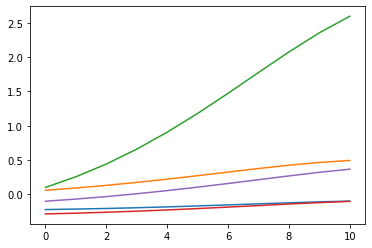

In [40]:
plt.plot(l_mavs[4,:,0])
plt.plot(l_mavs[4,:,1])
plt.plot(l_mavs[4,:,2])
plt.plot(l_mavs[4,:,3])
plt.plot(l_mavs[4,:,4])

# Output `.csv` files

In [25]:
col_names = [f'channel_{x}' for x in range(n_channels)]
sess_id = 1

n_cols = len(f_triggers)
for f_id, trigger_list in enumerate( f_triggers):
    col = f_id + 1

    for t_count, trigger in enumerate( trigger_list):

        epoch = mav_data [ trigger + 0 : trigger + N_FRAMES]

        df = pd.DataFrame(data = epoch, columns=col_names)
        df.index.name = 'timestamp'
        csv_name =f'session_{sess_id}.finger_{col:02}.sample_{t_count+1:02}.csv'
        df.head 

        # df.to_csv(PROJECT_PATH + '/output/' + csv_name)
    print(csv_name)
print('DONE!')

session_1.finger_01.sample_61.csv
session_1.finger_02.sample_55.csv
session_1.finger_03.sample_60.csv
session_1.finger_04.sample_60.csv
session_1.finger_05.sample_60.csv
DONE!


In [26]:
down_fig.update_layout( title_text = 'Downsampled EMG Envelope Data',
                       title_font_size = 30,
                       xaxis_title = 'Time [s]',
                       yaxis_title = 'Arbitrary A/D Units',
                       template = 'plotly_white')
down_fig.show()


scale_fig.update_layout( title_text = 'Scaled EMG Data',
                       title_font_size = 30,
                       xaxis_title = 'Time [s]',
                       yaxis_title = 'Arbitrary A/D Units',
                       template = 'plotly_white')
scale_fig.show()


mav_fig.update_layout( title_text = 'MAV of Scaled Data',
                       title_font_size = 30,
                       xaxis_title = r'$i^{th}\, \text{Window}$',
                       yaxis_title = 'Arbitrary A/D Units',
                       template = 'plotly_white')
mav_fig.show()

Output hidden; open in https://colab.research.google.com to view.

This is example of filtering data recorded at 200Hz with high pass filter with cutoff at 1Hz
Use this link to generate coefficients a0, a1, a2, b1, b2 below for different sample rate and/or different cutoff frequency:

https://www.earlevel.com/main/2013/10/13/biquad-calculator-v2/ 

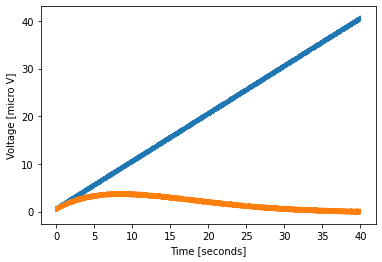

In [27]:
a0 = 0.9995480342282792
a1 = -1.9990960684565584
a2 = 0.9995480342282792
b1 = -1.9990958641874053
b2 = 0.9990962727257113

a = np.array([a0, a1, a2], dtype=np.float32)
b = np.array([b1,b2], dtype=np.float32)
x = np.array([0,0,0], dtype=np.float32)
y = np.array([0,0], dtype=np.float32)

def filterData(newValue):
  x[2] = x[1]
  x[1] = x[0]
  x[0] = np.float32(newValue)
  filteredData = a[0]*x[0]+a[1]*x[1]+a[2]*x[2]-b[0]*y[0]-b[1]*y[1]
  y[1] = y[0]
  y[0] = filteredData
  return filteredData

def initFilter():
    x[0] = 0
    x[1] = 0
    x[2] = 0
    y[0] = 0
    y[1] = 0

#-----------------------------------------------------------------------------------------
#                          END OF FILTER CODE
#-----------------------------------------------------------------------------------------



import math
from numpy.random import seed
from numpy.random import rand
import time
import matplotlib.pyplot as plt
seed(int(time.time()%10000))


#generate random test signal with trend
signal = rand(8000)
#sample rate
fs = 200
length_of_signal = len(signal)
time_axis_data = np.linspace(0,length_of_signal/fs,length_of_signal)
signal = signal+time_axis_data




#apply filter to simulated signal

initFilter()
filteredArray = np.array([], dtype=np.float32)
for oneSample in signal:
  filteredArray = np.append(filteredArray, filterData(oneSample))




# plot original signal
plt.plot(time_axis_data,signal)
#  plot filtered signal
plt.plot(time_axis_data,filteredArray)
# naming the x axis
plt.xlabel('Time [seconds]')
# naming the y axis
plt.ylabel('Voltage [micro V]')
plt.show()